In [22]:
#%reset
import os
rundir='/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/SCRIPTS/cfc/'
os.chdir(rundir)
import sys
sys.path.append('../PMODS')

import csv
import rms_plots_v2 as rpl
import rms_utils_boot as rutb
import matplotlib.pyplot as plt # for basic plotting
import numpy as np
from netCDF4 import Dataset
import nc as nc
import glob
import xarray as xr
from scipy import stats
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as gridspec
plt.style.use('rms_paper')

ystart=1955;ystop=2005;nyear=ystop+1-ystart
years=range(ystart,ystop+1)
print(nyear)

51


In [23]:
#######################################
### 1.1 READ ERF DATA##################
#######################################
os.chdir(rundir)

###################
### 1.1.1 AR6######
###################

##############declare variables

years=np.arange(1955,2005+1,1);
years2=np.zeros_like(years);nyear=len(years)

erf_ar6={'co2':np.zeros((3,nyear)),
      'ch4':np.zeros((3,nyear)),
      'n2o':np.zeros((3,nyear)),
      'aer':np.zeros((3,nyear)),
      'tot':np.zeros((3,nyear)),
      'o3':np.zeros((3,nyear)),
      'ods':np.zeros((3,nyear)),
      'ghg':np.zeros((3,nyear))}

labels_erf={'co2':'CO$_2$',
        'ch4':'CH$_4$',
        'n2o':'N$_2$O',
        'aer':'AER',
        'tot':'ALL',
        'o3':'O$_3$',
        'ods':'ODS'}
#####################general file (mean)
with open('DATA/AR6/IN_ERF_AR6/AR6_ERF_1750-2019.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    line_count=0
    i=0
    for row in lines:
        if line_count==0:
            titles=row
        elif line_count>205 and line_count<257:            
            years2[i]=row[0]
            erf_ar6['co2'][0,i]=float(row[1])
            erf_ar6['ch4'][0,i]=float(row[2])
            erf_ar6['n2o'][0,i]=float(row[3])
            erf_ar6['o3'][0,i]=float(row[5])
            erf_ar6['aer'][0,i]=float(row[15])
            erf_ar6['tot'][0,i]=float(row[19])
            i+=1
        line_count+=1    

    print (titles[1],titles[2],titles[3],titles[5],titles[15],titles[19])

#####################general file (5%)
with open('DATA/AR6/IN_ERF_AR6/AR6_ERF_1750-2019_pc05.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    line_count=0
    i=0
    for row in lines:
        if line_count==0:
            titles=row
        elif line_count>205 and line_count<257:            
            years2[i]=row[0]
            erf_ar6['co2'][1,i]=float(row[1])
            erf_ar6['ch4'][1,i]=float(row[2])
            erf_ar6['n2o'][1,i]=float(row[3])
            erf_ar6['o3'][1,i]=float(row[5])
            erf_ar6['aer'][1,i]=float(row[15])
            erf_ar6['tot'][1,i]=float(row[19])
            i+=1
        line_count+=1    

    print (titles[1],titles[2],titles[3],titles[5],titles[15],titles[19])
#####################general file (95%)
with open('DATA/AR6/IN_ERF_AR6/AR6_ERF_1750-2019_pc95.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    line_count=0
    i=0
    for row in lines:
        if line_count==0:
            titles=row
        elif line_count>205 and line_count<257:            
            years2[i]=row[0]
            erf_ar6['co2'][2,i]=float(row[1])
            erf_ar6['ch4'][2,i]=float(row[2])
            erf_ar6['n2o'][2,i]=float(row[3])
            erf_ar6['o3'][2,i]=float(row[5])
            erf_ar6['aer'][2,i]=float(row[15])
            erf_ar6['tot'][2,i]=float(row[19])
            i+=1
        line_count+=1    

    print (titles[1],titles[2],titles[3],titles[5],titles[15],titles[19])

#####################GHG (5+95%)
with open('DATA/AR6/IN_ERF_AR6/AR6_ERF_GHGs_incl_not_well_mixed_1955-2019.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    line_count=0
    i=0
    for row in lines:
        if line_count==0:
            titles=row
        elif line_count>0 and line_count<52:            
            years2[i]=row[0]
            erf_ar6['ghg'][0,i]=float(row[1])
            erf_ar6['ghg'][2,i]=float(row[2])
            erf_ar6['ghg'][1,i]=(erf_ar6['ghg'][0,i]+erf_ar6['ghg'][2,i])/2.
            i+=1
        line_count+=1    

print (titles[1],titles[2])
print (years2)


#####################ods (mean)
with open('DATA/AR6/IN_ERF_AR6/AR6_ERF_minorGHGs_1750-2019_MS.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    line_count=0
    i=0
    for row in lines:
        if line_count==0:
            titles=row
        elif line_count>205 and line_count<257:            
            years2[i]=row[0]
            erf_ar6['ods'][0,i]=float(row[51])
            i+=1
        line_count+=1    

    print (titles[51])
#####################ODS uncertainty
erf_ar6['ods'][1,:]=erf_ar6['ods'][0,:]*0.81
erf_ar6['ods'][2,:]=erf_ar6['ods'][0,:]*1.19


#######################################
### 1.1.2 TOA UNCOUPLED (ERF CanESM5)##
#######################################
nens=20

########## NEW: GM+ZM from netcdf files
erf={};erf_zm={};erf_2d={};files={};files_zm={};files_2d={}

exp_names_erf={'historical':'fall',
           'fixODS':'fods',
           'fixCO2':'fco2',
           'fixaerosol':'faer'}


os.chdir(rundir)
lat=nc.getvar('DATA/CanESM5_uncoupled/DATA_rtmt_canesm5_past_fall/zmam_rtmt_Amon_CanESM5-jcl-tods-embc55-fall-01_piClim-histall_r1i1p2f1_gn_195401-200512.nc','lat'); nlat=np.size(lat)
lon=nc.getvar('DATA/CanESM5_uncoupled/DATA_rtmt_canesm5_past_fall/am_rtmt_Amon_CanESM5-jcl-tods-embc55-fall-01_piClim-histall_r1i1p2f1_gn_195401-200512.nc','lon'); nlon=np.size(lon)

for forcing in ['historical','fixODS','fixCO2','fixaerosol']:
    os.chdir(rundir)
    os.chdir('DATA/CanESM5_uncoupled/DATA_rtmt_canesm5_past_{}'.format(exp_names_erf[forcing]))
    files[forcing]=[];files_zm[forcing]=[];files_2d[forcing]=[]
    #make file lists
    for i in range(nens): 
        files[forcing].extend(glob.glob('gmam_*'+exp_names_erf[forcing]+'-'+str(i+1).zfill(2)+'_piClim*'))
        files_zm[forcing].extend(glob.glob('zmam_*'+exp_names_erf[forcing]+'-'+str(i+1).zfill(2)+'_piClim*'))
        files_2d[forcing].extend(glob.glob('am_*'+exp_names_erf[forcing]+'-'+str(i+1).zfill(2)+'_piClim*'))
        
    #declare variables
    erf[forcing]=np.zeros((nens,nyear))*np.nan
    erf_zm[forcing]=np.zeros((nens,nyear,nlat))*np.nan
    erf_2d[forcing]=np.zeros((nens,nyear,nlat,nlon))*np.nan

    #read data
    for i,file in enumerate(files[forcing]): erf[forcing][i,:]=xr.open_dataset(file).rtmt.squeeze()
    for i,file in enumerate(files_zm[forcing]): erf_zm[forcing][i,:,:]=xr.open_dataset(file).rtmt.squeeze()
    for i,file in enumerate(files_2d[forcing]): erf_2d[forcing][i,:,:,:]=xr.open_dataset(file).rtmt.squeeze()
        


co2 ch4 n2o o3 aerosol total
co2 ch4 n2o o3 aerosol total
co2 ch4 n2o o3 aerosol total
p05 p95
[1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968
 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982
 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005]



In [24]:
#######################################
### 1.2 READ GSAT DATA##################
#######################################

########################
### 1.2.1 GSAT CanESM5##
########################
exp_names={'historical':'historical',
           'fixODSO3':'hist-noCFC-noO3',
           'fixODS':'hist-noCFC',
           'fixaerosol':'hist-noaerosol',
           'fixCO2':'hist-noCO2'}

gsat={};asat={}
files_gsat={};files_asat={}

os.chdir(rundir)
for forcing in exp_names.keys():
    #print forcing
    os.chdir('DATA/CanESM5/DATA_tas_canesm5_past_{}'.format(exp_names[forcing]))
    #make file lists
    files_gsat[forcing]=[];files_asat[forcing]=[]
    for i in range(nens): 
        files_gsat[forcing].extend(glob.glob('gmam*_'+exp_names[forcing]+'_*r'+str(i+1)+'i1p2f1*'))
        files_asat[forcing].extend(glob.glob('arcam*_'+exp_names[forcing]+'_*r'+str(i+1)+'i1p2f1*'))
    #declare variables
    gsat[forcing]=np.zeros((nens,nyear))*np.nan;asat[forcing]=np.zeros((nens,nyear))*np.nan
    #read data
    for i,file in enumerate(files_gsat[forcing]):
        df=xr.open_dataset(file)
        gsat[forcing][i,:]=(df.sel(time=slice(str(ystart),str(ystop))).tas.data).squeeze() 
    for i,file in enumerate(files_asat[forcing]):
        df=xr.open_dataset(file)
        asat[forcing][i,:]=(df.sel(time=slice(str(ystart),str(ystop))).tas.data).squeeze() 

    os.chdir(rundir)

########################
### 1.2.2 OBSERVATIONS##
########################
tasfile=xr.open_dataset('DATA/OBSERVATIONS/DATA_tas_obs_past/SAT_HadCRUT_am_gm_1950_2005.nc')
gsat_obs=tasfile.tas_mean.sel(time=slice('1955-01-01', '2005-12-31')).squeeze()
tasfile=xr.open_dataset('DATA/OBSERVATIONS/DATA_tas_obs_past/SAT_HadCRUT_am_arc_1950_2005.nc')
asat_obs=tasfile.tas_mean.sel(time=slice('1955-01-01', '2005-12-31')).squeeze()
os.chdir(rundir)

#######################################
### 1.3 READ SSIE DATA##################
#######################################

########################
### 1.3.1 SSIE CanESM5##
########################
ssie={}
files_ssie={}

os.chdir(rundir)
for forcing in exp_names.keys():
    #print forcing
    os.chdir('DATA/CanESM5/DATA_siconc_canesm5_past_{}'.format(exp_names[forcing]))
    #make file lists
    files_ssie[forcing]=[]
    for i in range(nens): 
        files_ssie[forcing].extend(glob.glob('ssie*_'+exp_names[forcing]+'_*r'+str(i+1)+'i1p2f1*'))
    #declare variables
    ssie[forcing]=np.zeros((nens,nyear))*np.nan
    #read data
    for i,file in enumerate(files_ssie[forcing]):
        df=xr.open_dataset(file)
        ssie[forcing][i,:]=(df.sel(time=slice(str(ystart),str(ystop))).siconc.data).squeeze() 
    os.chdir(rundir)

########################
### 1.3.2 SSIE OBS##
########################
ssie_obs=nc.getvar('DATA/OBSERVATIONS/DATA_SIC_obs_past/SSIE.nc','seaice_conc').squeeze()*1e-12

In [25]:

#####################################################################
### 1.4 READ TAO COUPLED (global mean from RTD)######################
#####################################################################

exp_names_toa={'historical':'p2-his',
                 'fixODSO3':'rms0058',
                   'fixODS':'rms0056',
               'fixaerosol':'rms0066',
                   'fixCO2':'rms0065'}

toa={}
files_toa={}

os.chdir(rundir)
for forcing in exp_names.keys():
    #print forcing
    os.chdir('DATA/CanESM5/IN_TOA_COUPLED_CanESM5/')
    #make file lists
    files_toa[forcing]=[]
    for i in range(nens): 
        if forcing=='historical':
            files_toa[forcing].extend(glob.glob('sc_p2-his'+str(i+1).zfill(2)+'_1850_2014_rtd074.nc'))
        else:
            files_toa[forcing].extend(glob.glob('sc_'+exp_names_toa[forcing]+'-'+str(i+1).zfill(3)+'_195501_201412_rtd074.nc'))
    #print (files_toa[forcing])
    #declare variables
    toa[forcing]=np.zeros((nens,nyear))*np.nan;
    #read data
    for i,file in enumerate(files_toa[forcing]):
        if forcing=='historical':
            toa[forcing][i,:]=nc.getvar(file,'BALT')[105:155+1].squeeze()
        else:
            toa[forcing][i,:]=nc.getvar(file,'BALT')[0:50+1].squeeze()

    os.chdir(rundir)



In [26]:
#####################################################
##2. Calculations such as  running means
#####################################################
###############runing mean function 
nyear_rm=5
def calc_rm(x):
    x_rm=np.zeros_like(x)*np.nan;dx_rm=np.zeros_like(x)*np.nan
    n=np.shape(x)[0]; nyear=np.shape(x)[1]
    for i in range(n):
        for iyear in range(nyear_rm-1,nyear):
            istart=iyear-nyear_rm+1;istop=iyear+1
            x_rm[i,iyear] =np.mean(x[i,istart:istop]) # running mean, in iyear from iyear-nyear_rm+1 to and including iyear 
            dx_rm[i,iyear]=np.mean(x[i,istart:istop])-np.mean(x[i,0:nyear_rm]) #running mean, relative to first running mean
            #print iyear,istart,istop
    return x_rm,dx_rm

###############
##2.1.1 ERF-AR6##
###############
# remove 1955 values all forcings as for ar6 the erf is given directly and not calculated from difference between all and fixed forcing
erf_ar6_cf1955={}
                
for forcing in (sorted(erf_ar6.keys())):
    erf_ar6_cf1955[forcing]=np.zeros((3,nyear))
    for i in range(3):
        erf_ar6_cf1955[forcing][i,:]=erf_ar6[forcing][i,:]-erf_ar6[forcing][i,0] 

#####################running mean ERF (running mean and running mean compared to first 'nyear_rm' year mean; year corresponds to endyear)
erf_ar6_rm={};derf_ar6_rm={}
for forcing in sorted(erf_ar6.keys()): 
    erf_ar6_rm[forcing],derf_ar6_rm[forcing]=calc_rm(erf_ar6[forcing])

##################
##2.1.2 ERF-CanESM5#
##################
erf_cf1955={}
#####################remove 1955 value
for forcing in erf.keys():
    erf_cf1955[forcing]=np.zeros_like(erf['historical'])*np.nan 
    for i in range(nens):
        erf_cf1955[forcing][i,:]=erf[forcing][i,:]-erf[forcing][i,0]

#####################running mean ERF (running mean and running mean compared to first 'nyear_rm' year mean; year corresponds to endyear)
erf_rm={};erf_rm_cf1955={}
for forcing in sorted(erf.keys()): 
    erf_rm[forcing],erf_rm_cf1955[forcing]=calc_rm(erf[forcing])

######definitions paper (total ERF for 1955 to 2005 period)
dERF={};dERF_mean={} 
dERF['ods']=erf_rm['historical'][:,-1]-erf_rm['fixODS'][:,-1]     
dERF['co2']=erf_rm['historical'][:,-1]-erf_rm['fixCO2'][:,-1]  
dERF['aer']=erf_rm['historical'][:,-1]-erf_rm['fixaerosol'][:,-1]
dERF['antw']=np.mean(erf_cf1955['fixaerosol'][:,-nyear_rm::],axis=1)
dERF['all']=np.mean(erf_cf1955['historical'][:,-nyear_rm::],axis=1)
dERF['odso3']=np.nan

for forcing in ['ods','co2','aer','antw','all']: dERF_mean[forcing]=np.mean(dERF[forcing])

###################
##2.2 GSAT-CanESM5#
###################

#####################remove 1955 value
gsat_cf1955={};asat_cf1955={}
for forcing in gsat.keys():
    gsat_cf1955[forcing]=np.zeros_like(gsat['historical'])*np.nan
    asat_cf1955[forcing]=np.zeros_like(asat['historical'])*np.nan
    for i in range(nens):
        gsat_cf1955[forcing][i,:]=gsat[forcing][i,:]-gsat[forcing][i,0]
        asat_cf1955[forcing][i,:]=asat[forcing][i,:]-asat[forcing][i,0]

#####################running mean(year corresponds to endyear, so last year is mean of last nyear_rm years)
gsat_rm={};gsat_cf1955_rm={}
asat_rm={};asat_cf1955_rm={}
for forcing in sorted(gsat.keys()): 
    gsat_rm[forcing],gsat_cf1955_rm[forcing]=calc_rm(gsat[forcing])
    asat_rm[forcing],asat_cf1955_rm[forcing]=calc_rm(asat[forcing])

######definitions paper (total dT for 1955 to 2005 period)
dGSAT={};dGSAT_mean={}

##GSAT
dGSAT['all']=np.mean(gsat_cf1955['historical'][:,-nyear_rm::],axis=1); 
dGSAT['fods']=np.mean(gsat_cf1955['fixODS'][:,-nyear_rm::],axis=1);     
dGSAT['fco2']=np.mean(gsat_cf1955['fixCO2'][:,-nyear_rm::],axis=1);    
dGSAT['antw']=np.mean(gsat_cf1955['fixaerosol'][:,-nyear_rm::],axis=1) 

dGSAT['ods']=gsat_rm['historical'][:,-1]-gsat_rm['fixODS'][:,-1]     
dGSAT['odso3']=gsat_rm['historical'][:,-1]-gsat_rm['fixODSO3'][:,-1]  
dGSAT['co2']=gsat_rm['historical'][:,-1]-gsat_rm['fixCO2'][:,-1]  
dGSAT['aer']=gsat_rm['historical'][:,-1]-gsat_rm['fixaerosol'][:,-1] 


##ASAT
dASAT={};dASAT_mean={}
dASAT['all']=np.mean(asat_cf1955['historical'][:,-nyear_rm::],axis=1); 
dASAT['fods']=np.mean(asat_cf1955['fixODS'][:,-nyear_rm::],axis=1);     
dASAT['fco2']=np.mean(asat_cf1955['fixCO2'][:,-nyear_rm::],axis=1);    
dASAT['antw']=np.mean(asat_cf1955['fixaerosol'][:,-nyear_rm::],axis=1) 

dASAT['ods']=asat_rm['historical'][:,-1]-asat_rm['fixODS'][:,-1]     
dASAT['odso3']=asat_rm['historical'][:,-1]-asat_rm['fixODSO3'][:,-1]  
dASAT['co2']=asat_rm['historical'][:,-1]-asat_rm['fixCO2'][:,-1]  
dASAT['aer']=asat_rm['historical'][:,-1]-asat_rm['fixaerosol'][:,-1]

for forcing in ['all','fods','fco2','antw','ods','odso3','co2','aer']: 
    dGSAT_mean[forcing]=np.mean(dGSAT[forcing])
    dASAT_mean[forcing]=np.mean(dASAT[forcing])


###################
##2.3 SSIE-CanESM5#
###################

#####################remove 1955 value
ssie_cf1955={}
for forcing in ssie.keys():
    ssie_cf1955[forcing]=np.zeros_like(ssie['historical'])*np.nan
    for i in range(nens):
        ssie_cf1955[forcing][i,:]=ssie[forcing][i,:]-ssie[forcing][i,0]

#####################running mean SSIE (running mean and running mean compared to first 'nyearrunning' year mean; year corresponds to endyear)
ssie_rm={};ssie_rm_cf1955={}
for forcing in sorted(gsat.keys()): 
    ssie_rm[forcing],ssie_rm_cf1955[forcing]=calc_rm(ssie[forcing])


######definitions paper
##SSIE# 
dSSIE={};dSSIE_mean={}
dSSIE['all']=np.mean(ssie_cf1955['historical'][:,-nyear_rm::],axis=1); 
dSSIE['fods']=np.mean(ssie_cf1955['fixODS'][:,-nyear_rm::],axis=1);     
dSSIE['fco2']=np.mean(ssie_cf1955['fixCO2'][:,-nyear_rm::],axis=1);    
dSSIE['antw']=np.mean(ssie_cf1955['fixaerosol'][:,-nyear_rm::],axis=1) 

dSSIE['ods']=ssie_rm['historical'][:,-1]-ssie_rm['fixODS'][:,-1]     
dSSIE['odso3']=ssie_rm['historical'][:,-1]-ssie_rm['fixODSO3'][:,-1]  
dSSIE['co2']=ssie_rm['historical'][:,-1]-ssie_rm['fixCO2'][:,-1]  
dSSIE['aer']=ssie_rm['historical'][:,-1]-ssie_rm['fixaerosol'][:,-1]

for forcing in ['all','fods','fco2','antw','ods','odso3','co2','aer']: dSSIE_mean[forcing]=np.mean(dSSIE[forcing])


###################
##2.4 TOA-CanESM5#####
###################
toa_rm={};toa_rm_cf1955={};
for forcing in sorted(toa.keys()): 
    toa_rm[forcing],toa_rm_cf1955[forcing]=calc_rm(toa[forcing])
######definitions paper
##TOA# 
dTOA={};dTOA_mean={}
dTOA['ods']=toa_rm['historical'][:,-1]-toa_rm['fixODS'][:,-1]     
dTOA['co2']=toa_rm['historical'][:,-1]-toa_rm['fixCO2'][:,-1]     

for forcing in ['ods','co2']: dTOA_mean[forcing]=np.mean(dTOA[forcing])



###################
##2.5 efficacy#####
###################

eff_ods_rm=np.zeros((nens,nyear))

for i in range(nens):
    eff_ods_rm[i,:]=((gsat_rm['historical'][i,:]-gsat_rm['fixODS'][i,:])/(erf_rm['historical'][i,:]-erf_rm['fixODS'][i,:]))/\
                    ((gsat_rm['historical'][i,:]-gsat_rm['fixCO2'][i,:])/(erf_rm['historical'][i,:]-erf_rm['fixCO2'][i,:]))

eff_ods_rm_means=(np.mean(gsat_rm['historical']-gsat_rm['fixODS'],axis=0)/np.mean(erf_rm['historical']-erf_rm['fixODS'],axis=0))/\
                 (np.mean(gsat_rm['historical']-gsat_rm['fixCO2'],axis=0)/np.mean(erf_rm['historical']-erf_rm['fixCO2'],axis=0)) 


EFF_ods_means=(dGSAT_mean['ods']/dERF_mean['ods'])/(dGSAT_mean['co2']/dERF_mean['co2'])
EFF_ods=(dGSAT['ods']/dERF['ods'])/(dGSAT['co2']/dERF['co2'])



########################
##2.6 bootstrapping#####
########################

#Function####
nboot=100000
def calc_boot_mean(x):
    nens=len(x)
    xmean_b=np.zeros((nboot))
    for iboot in range(nboot):
        resample_i = np.floor(np.random.rand(nens+1)*nens).astype(int)
        xmean_b[iboot]=np.mean(x[resample_i])
    return xmean_b

#GSAT####
dGSAT_meanb={};dGSAT_meanb_mean={};dGSAT_meanb_min={};dGSAT_meanb_max={}
for forcing in ['all','fods','ods','odso3','fco2','co2','aer','antw']:
    dGSAT_meanb[forcing]=calc_boot_mean(dGSAT[forcing])
    dGSAT_meanb_mean[forcing],dGSAT_meanb_min[forcing],dGSAT_meanb_max[forcing],a=rutb.calc_boot_stats(dGSAT_meanb[forcing])


dGSAT_meanb_mean['reduction_ods'],dGSAT_meanb_min['reduction_ods'],dGSAT_meanb_max['reduction_ods'],a=rutb.calc_boot_stats(dGSAT_meanb['ods']/dGSAT_meanb['all'])
dGSAT_meanb_mean['reduction_co2'],dGSAT_meanb_min['reduction_co2'],dGSAT_meanb_max['reduction_co2'],a=rutb.calc_boot_stats(dGSAT_meanb['co2']/dGSAT_meanb['all'])

dGSAT_meanb_mean['ods_antw'],dGSAT_meanb_min['ods_antw'],dGSAT_meanb_max['ods_antw'],a=rutb.calc_boot_stats((dGSAT_meanb['ods'])/dGSAT_meanb['antw'])
dGSAT_meanb_mean['ods_co2'],dGSAT_meanb_min['ods_co2'],dGSAT_meanb_max['ods_co2'],a=rutb.calc_boot_stats((dGSAT_meanb['ods'])/dGSAT_meanb['co2'])
dGSAT_meanb_mean['co2_antw'],dGSAT_meanb_min['co2_antw'],dGSAT_meanb_max['co2_antw'],a=rutb.calc_boot_stats((dGSAT_meanb['co2'])/dGSAT_meanb['antw'])

#ERF####
dERF_meanb={};dERF_meanb_mean={};dERF_meanb_min={};dERF_meanb_max={}
for forcing in ['ods','co2','aer','antw','all']:
    dERF_meanb[forcing]=calc_boot_mean(dERF[forcing])
    dERF_meanb_mean[forcing],dERF_meanb_min[forcing],dERF_meanb_max[forcing],a=rutb.calc_boot_stats(dERF_meanb[forcing])

dERF_meanb_mean['ods_antw'],dERF_meanb_min['ods_antw'],dERF_meanb_max['ods_antw'],a=rutb.calc_boot_stats((dERF_meanb['ods'])/dERF_meanb['antw'])
dERF_meanb_mean['ods_co2'],dERF_meanb_min['ods_co2'],dERF_meanb_max['ods_co2'],a=rutb.calc_boot_stats((dERF_meanb['ods'])/dERF_meanb['co2'])
dERF_meanb_mean['co2_antw'],dERF_meanb_min['co2_antw'],dERF_meanb_max['co2_antw'],a=rutb.calc_boot_stats((dERF_meanb['co2'])/dERF_meanb['antw'])


#EFFICACY when calculated based ratio of means
dEFF_meanb_mean={};dEFF_meanb_min={};dEFF_meanb_max={}
for forcing in ['ods','aer']:
    dEFF_meanb_mean[forcing],dEFF_meanb_min[forcing],dEFF_meanb_max[forcing],a=rutb.calc_boot_stats((dGSAT_meanb[forcing]/dERF_meanb[forcing])/(dGSAT_meanb['co2']/dERF_meanb['co2']))

#EFFICACY when calculated based mean of ratios
dEFF_meanb_mean2={};dEFF_meanb_min2={};dEFF_meanb_max2={}
dEFF_meanb_mean2['ods'],dEFF_meanb_min2['ods'],dEFF_meanb_max2['ods'],a=rutb.calc_boot_stats(calc_boot_mean(EFF_ods))


#ASAT
dASAT_meanb={};dASAT_meanb_mean={};dASAT_meanb_min={};dASAT_meanb_max={}
for forcing in ['all','fods','ods','odso3','fco2','co2','aer','antw']:
    dASAT_meanb[forcing]=calc_boot_mean(dASAT[forcing])
    dASAT_meanb_mean[forcing],dASAT_meanb_min[forcing],dASAT_meanb_max[forcing],a=rutb.calc_boot_stats(dASAT_meanb[forcing])
dASAT_meanb_mean['reduction_ods'],dASAT_meanb_min['reduction_ods'],dASAT_meanb_max['reduction_ods'],a=rutb.calc_boot_stats(dASAT_meanb['ods']/dASAT_meanb['all'])
dASAT_meanb_mean['reduction_co2'],dASAT_meanb_min['reduction_co2'],dASAT_meanb_max['reduction_co2'],a=rutb.calc_boot_stats(dASAT_meanb['co2']/dASAT_meanb['all'])

dASAT_meanb_mean['ods_antw'],dASAT_meanb_min['ods_antw'],dASAT_meanb_max['ods_antw'],a=rutb.calc_boot_stats((dASAT_meanb['ods'])/dASAT_meanb['antw'])
dASAT_meanb_mean['ods_co2'],dASAT_meanb_min['ods_co2'],dASAT_meanb_max['ods_co2'],a=rutb.calc_boot_stats((dASAT_meanb['ods'])/dASAT_meanb['co2'])
dASAT_meanb_mean['co2_antw'],dASAT_meanb_min['co2_antw'],dASAT_meanb_max['co2_antw'],a=rutb.calc_boot_stats((dASAT_meanb['co2'])/dASAT_meanb['antw'])

#AA
AA_meanb={};AA_meanb_mean={};AA_meanb_min={};AA_meanb_max={}
for forcing in ['co2','ods','odso3']:
    AA_meanb_mean[forcing],AA_meanb_min[forcing],AA_meanb_max[forcing],a=rutb.calc_boot_stats((dASAT_meanb[forcing])/dGSAT_meanb[forcing])


#SSIE
dSSIE_meanb={};dSSIE_meanb_mean={};dSSIE_meanb_min={};dSSIE_meanb_max={}
for forcing in ['all','fods','ods','odso3','fco2','co2','aer','antw']:
    dSSIE_meanb[forcing]=calc_boot_mean(dSSIE[forcing])
    dSSIE_meanb_mean[forcing],dSSIE_meanb_min[forcing],dSSIE_meanb_max[forcing],a=rutb.calc_boot_stats(dSSIE_meanb[forcing])

dSSIE_meanb_mean['reduction_ods'],dSSIE_meanb_min['reduction_ods'],dSSIE_meanb_max['reduction_ods'],a=rutb.calc_boot_stats((dSSIE_meanb['all']-dSSIE_meanb['fods'])/dSSIE_meanb['all'])
dSSIE_meanb_mean['reduction_co2'],dSSIE_meanb_min['reduction_co2'],dSSIE_meanb_max['reduction_co2'],a=rutb.calc_boot_stats((dSSIE_meanb['all']-dSSIE_meanb['fco2'])/dSSIE_meanb['all'])

dSSIE_meanb_mean['ods_antw'],dSSIE_meanb_min['ods_antw'],dSSIE_meanb_max['ods_antw'],a=rutb.calc_boot_stats((dSSIE_meanb['ods'])/dSSIE_meanb['antw'])
dSSIE_meanb_mean['ods_co2'],dSSIE_meanb_min['ods_co2'],dSSIE_meanb_max['ods_co2'],a=rutb.calc_boot_stats((dSSIE_meanb['ods'])/dSSIE_meanb['co2'])
dSSIE_meanb_mean['co2_antw'],dSSIE_meanb_min['co2_antw'],dSSIE_meanb_max['co2_antw'],a=rutb.calc_boot_stats((dSSIE_meanb['co2'])/dSSIE_meanb['antw'])

#TOA
dTOA_meanb={};dTOA_meanb_mean={};dTOA_meanb_min={};dTOA_meanb_max={}
for forcing in ['ods','co2']:
    dTOA_meanb[forcing]=calc_boot_mean(dTOA[forcing])

#feedback
fb_meanb={};fb_meanb_mean={};fb_meanb_min={};fb_meanb_max={}
fb_meanb_mean['ods'],fb_meanb_min['ods'],fb_meanb_max['ods'],a=rutb.calc_boot_stats(dGSAT_meanb['ods']/(dERF_meanb['ods']-dTOA_meanb['ods']))
fb_meanb_mean['co2'],fb_meanb_min['co2'],fb_meanb_max['co2'],a=rutb.calc_boot_stats(dGSAT_meanb['co2']/(dERF_meanb['co2']-dTOA_meanb['co2']))
fb_meanb_mean['ods_co2'],fb_meanb_min['ods_co2'],fb_meanb_max['ods_co2'],a=rutb.calc_boot_stats((dGSAT_meanb['ods']/(dERF_meanb['ods']-dTOA_meanb['ods']))/(dGSAT_meanb['co2']/(dERF_meanb['co2']-dTOA_meanb['co2'])))





In [27]:
#####################################################
##3. Calculate ODS and aerosol efficacies
#####################################################
tf = open('DATA/data_GSAT+ASAT+ERF+efficacies_'+str(2005+1-nyear_rm)+'-2005min1955.txt', "w")

####GSAT [2005+1-nyear_rm]-2005 min 1955 
tf.write('\n')
tf.write('\n*************GSAT   '+str(2005+1-nyear_rm)+'-2005 minus 1955**********')

for forcing in ['all','fods','ods','odso3','fco2','co2','aer','antw']:
    tf.write('\ndGSAT_{}     : {}, {}, {}, {}'.format(forcing,"%5.4f"%(dGSAT_mean[forcing]),"%5.4f"%(dGSAT_meanb_mean[forcing]),"%5.4f"%(dGSAT_meanb_min[forcing]),"%5.4f"%(dGSAT_meanb_max[forcing])))


####GSAT ratios 
tf.write('\n')
tf.write('\n****GSAT ratios') 

tf.write('\nGSAT reduction due to ODS: {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dGSAT_mean['all']-dGSAT_mean['fods'])/dGSAT_mean['all']),"%5.2f"%(100*(dGSAT_meanb_mean['reduction_ods'])),"%5.2f"%(100*(dGSAT_meanb_min['reduction_ods'])),"%5.2f"%(100*(dGSAT_meanb_max['reduction_ods']))))
tf.write('\nGSAT reduction due to CO2: {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dGSAT_mean['all']-dGSAT_mean['fco2'])/dGSAT_mean['all']),"%5.2f"%(100*(dGSAT_meanb_mean['reduction_co2'])),"%5.2f"%(100*(dGSAT_meanb_min['reduction_co2'])),"%5.2f"%(100*(dGSAT_meanb_max['reduction_co2']))))


tf.write('\ndGSAT_ods/dGSAT_co2      : {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dGSAT_mean['ods']/dGSAT_mean['co2'])),"%5.2f"%(100*(dGSAT_meanb_mean['ods_co2'])),"%5.2f"%(100*(dGSAT_meanb_min['ods_co2'])),"%5.2f"%(100*(dGSAT_meanb_max['ods_co2']))))
tf.write('\ndGSAT_ods/dGSAT_antw     : {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dGSAT_mean['ods']/dGSAT_mean['antw'])),"%5.2f"%(100*(dGSAT_meanb_mean['ods_antw'])),"%5.2f"%(100*(dGSAT_meanb_min['ods_antw'])),"%5.2f"%(100*(dGSAT_meanb_max['ods_antw']))))
tf.write('\ndGSAT_co2/dGSAT_antw     : {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dGSAT_mean['co2']/dGSAT_mean['antw'])),"%5.2f"%(100*(dGSAT_meanb_mean['co2_antw'])),"%5.2f"%(100*(dGSAT_meanb_min['co2_antw'])),"%5.2f"%(100*(dGSAT_meanb_max['co2_antw']))))

tf.write('\n\n****ERF and efficacies') 

#ERF
for forcing in ['ods','co2','aer']:
    tf.write('\ndERF_'+forcing+' CanESM5 : {}, {}, {} , {}'.format("%6.3f"%(np.mean(dERF[forcing])),"%6.3f"%(np.mean(dERF_meanb_mean[forcing])),"%6.3f"%(np.mean(dERF_meanb_min[forcing])),"%6.3f"%(np.mean(dERF_meanb_max[forcing]))))
    tf.write('\ndERF_'+forcing+' CMIP6   mean: {} , min: {}, max:{}'.format("%6.3f"%(np.mean(erf_ar6_cf1955[forcing][0,-nyear_rm::])),"%6.3f"%(np.mean(erf_ar6_cf1955[forcing][1,-nyear_rm::])),"%6.3f"%(np.mean(erf_ar6_cf1955[forcing][2,-nyear_rm::]))))

tf.write('\ndGSAT_ods/dERF_ods: ' + "%6.3f"%(dGSAT_mean['ods']/dERF_mean['ods']))
tf.write('\ndGSAT_co2/dERF_co2: ' + "%6.3f"%(dGSAT_mean['co2']/dERF_mean['co2']))


tf.write('\nEfficacy ODS (means)  : {}, {}, {}, {}'.format("%6.3f"%(EFF_ods_means),"%6.3f"%(dEFF_meanb_mean['ods']),"%6.3f"%(dEFF_meanb_min['ods']),"%6.3f"%(dEFF_meanb_max['ods'])))
tf.write('\nEfficacy ODS (mean of): {}, {}, {}, {}'.format("%6.3f"%(np.mean(EFF_ods)),"%6.3f"%(dEFF_meanb_mean2['ods']),"%6.3f"%(dEFF_meanb_min2['ods']),"%6.3f"%(dEFF_meanb_max2['ods']))) 

t,p=stats.ttest_1samp(EFF_ods,1)
tf.write('\np-value that ODS differs from 1 (1-sided)'+"%6.3f"%(p/2)) 


#feedbacks

tf.write('\nfeedback_ods:'+"%6.3f"%(dGSAT_mean['ods']/(dERF_mean['ods']-dTOA_mean['ods'])))
tf.write('\nfeedback_ods2: {}, {},{}'.format("%6.3f"%(fb_meanb_mean['ods']),"%6.3f"%(fb_meanb_min['ods']),"%6.3f"%(fb_meanb_max['ods'])))
tf.write('\nfeedback_co2:'+"%6.3f"%(dGSAT_mean['co2']/(dERF_mean['co2']-dTOA_mean['co2'])))
tf.write('\nfeedback_co22: {}, {},{}'.format("%6.3f"%(fb_meanb_mean['co2']),"%6.3f"%(fb_meanb_min['co2']),"%6.3f"%(fb_meanb_max['co2'])))
tf.write('\nfeedback_ods/feedback_co2: {}, {}, {}'.format("%6.3f"%(fb_meanb_mean['ods_co2']),"%6.3f"%(fb_meanb_min['ods_co2']),"%6.3f"%(fb_meanb_max['ods_co2'])))



#tf.write('\nfeedback_ods_noN:'+"%6.3f"%(dGSAT_ods_mean/(F_ods_mean)))
#tf.write('\nfeedback_CO2_noN:'+"%6.3f"%(dGSAT_co2_mean/(F_co2_mean)))

####ASAT [2005+1-nyear_rm]-2005 min 1955 
tf.write('\n')
tf.write('\n*************ASAT   '+str(2005+1-nyear_rm)+'-2005 minus 1955**********')

for forcing in ['all','fods','ods','odso3','fco2','co2','aer','antw']:
    tf.write('\ndASAT_'+forcing+': '+"%5.4f"%(dASAT_mean[forcing]))

####ASAT ratios 
tf.write('\n')
tf.write('\n****ASAT ratios') 

tf.write('\nASAT reduction due to ODS: {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dASAT_mean['all']-dASAT_mean['fods'])/dASAT_mean['all']),"%5.2f"%(100*(dASAT_meanb_mean['reduction_ods'])),"%5.2f"%(100*(dASAT_meanb_min['reduction_ods'])),"%5.2f"%(100*(dASAT_meanb_max['reduction_ods']))))
tf.write('\nASAT reduction due to CO2: {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dASAT_mean['all']-dASAT_mean['fco2'])/dASAT_mean['all']),"%5.2f"%(100*(dASAT_meanb_mean['reduction_co2'])),"%5.2f"%(100*(dASAT_meanb_min['reduction_co2'])),"%5.2f"%(100*(dASAT_meanb_max['reduction_co2']))))

tf.write('\ndASAT_ods/dASAT_co2      : {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dASAT_mean['ods']/dASAT_mean['co2'])),"%5.2f"%(100*(dASAT_meanb_mean['ods_co2'])),"%5.2f"%(100*(dASAT_meanb_min['ods_co2'])),"%5.2f"%(100*(dASAT_meanb_max['ods_co2']))))
tf.write('\ndASAT_ods/dASAT_antw     : {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dASAT_mean['ods']/dASAT_mean['antw'])),"%5.2f"%(100*(dASAT_meanb_mean['ods_antw'])),"%5.2f"%(100*(dASAT_meanb_min['ods_antw'])),"%5.2f"%(100*(dASAT_meanb_max['ods_antw']))))
tf.write('\ndASAT_co2/dASAT_antw     : {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dASAT_mean['co2']/dASAT_mean['antw'])),"%5.2f"%(100*(dASAT_meanb_mean['co2_antw'])),"%5.2f"%(100*(dASAT_meanb_min['co2_antw'])),"%5.2f"%(100*(dASAT_meanb_max['co2_antw']))))

####Arctic amplficiation [2005+1-nyear_rm]-2005 min 1955 
tf.write('\n')
tf.write('\n****Arctic Amplification')
for forcing in ['co2','ods','odso3']:
    tf.write('\nAA_{}: {}, {}, {}, {}'.format(forcing,"%5.4f"%(dASAT_mean[forcing]/dGSAT_mean[forcing]),"%5.4f"%(AA_meanb_mean[forcing]),"%5.4f"%(AA_meanb_min[forcing]),"%5.4f"%(AA_meanb_max[forcing])))

#t,p=stats.ttest_ind(dASAT['co2']/dGSAT['co2'],dASAT['ods']/dGSAT['ods'])
#tf.write('\np-value that ArcAmp_co2 differs from ArcAmp_ods'+"%6.3f"%(p)) 

tf.write('\n')

####SSIE [2005+1-nyear_rm]-2005 min 1955 
tf.write('\n')
tf.write('\n*************SSIE   '+str(2005+1-nyear_rm)+'-2005 minus 1955**********')

for forcing in ['all','fods','ods','odso3','fco2','co2','aer','antw']:
    tf.write('\nSSIE_'+forcing+': '+"%5.4f"%(dSSIE_mean[forcing]))

####ASAT ratios 
tf.write('\n')
tf.write('\n****ASAT ratios') 

tf.write('\nSSIE reduction due to ODS: {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dSSIE_mean['all']-dSSIE_mean['fods'])/dSSIE_mean['all']),"%5.2f"%(100*(dSSIE_meanb_mean['reduction_ods'])),"%5.2f"%(100*(dSSIE_meanb_min['reduction_ods'])),"%5.2f"%(100*(dSSIE_meanb_max['reduction_ods']))))
tf.write('\nSSIE reduction due to CO2: {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dSSIE_mean['all']-dSSIE_mean['fco2'])/dSSIE_mean['all']),"%5.2f"%(100*(dSSIE_meanb_mean['reduction_co2'])),"%5.2f"%(100*(dSSIE_meanb_min['reduction_co2'])),"%5.2f"%(100*(dSSIE_meanb_max['reduction_co2']))))

tf.write('\ndSSIE_ods/dSSIE_co2      : {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dSSIE_mean['ods']/dSSIE_mean['co2'])),"%5.2f"%(100*(dSSIE_meanb_mean['ods_co2'])),"%5.2f"%(100*(dSSIE_meanb_min['ods_co2'])),"%5.2f"%(100*(dSSIE_meanb_max['ods_co2']))))
tf.write('\ndSSIE_ods/dSSIE_antw     : {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dSSIE_mean['ods']/dSSIE_mean['antw'])),"%5.2f"%(100*(dSSIE_meanb_mean['ods_antw'])),"%5.2f"%(100*(dSSIE_meanb_min['ods_antw'])),"%5.2f"%(100*(dSSIE_meanb_max['ods_antw']))))
tf.write('\ndSSIE_co2/dSSIE_antw     : {}%, {}%, {}%, {}%'.format("%5.2f"%(100*(dSSIE_mean['co2']/dSSIE_mean['antw'])),"%5.2f"%(100*(dSSIE_meanb_mean['co2_antw'])),"%5.2f"%(100*(dSSIE_meanb_min['co2_antw'])),"%5.2f"%(100*(dSSIE_meanb_max['co2_antw']))))


tf.close()


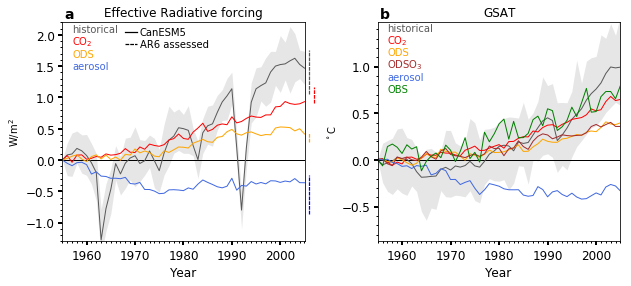

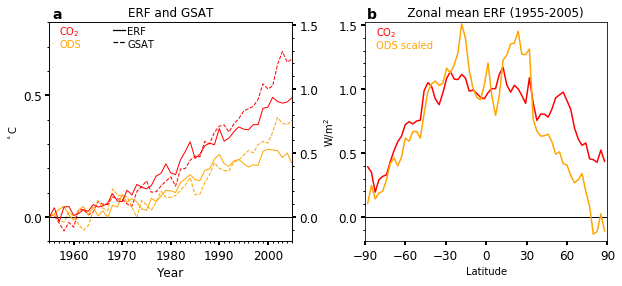

In [28]:
#####################################################
##4. PLOTS
#####################################################
colors={'historical':[0.35,0.35,0.35],
        'fixODS':'orange',
        'fixODSO3':'brown',
        'fixaerosol':'royalblue',
        'fixCO2':'red',
        'AntW':'purple'        
       } 
colors_ar6_erf={'co2':'red',
        'ch4':'magenta',
        'n2o':'cyan',
        'aer':'blue',
        'tot':[0.35,0.35,0.35],
        'o3':'brown',
        'ods':'orange'}
labels_dif={'historical':'historical',
        'fixODS':'ODS',
        'fixCO2': 'CO$_2$',
        'fixaerosol':'aerosol',
        'fixODSO3':'ODSO$_3$',
        'AntW':'AntW'}

##################################
##4.1a. Timeseries ERF+GSAT#
##################################

fig1, axs = plt.subplots(1,2, figsize=(10,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.05,wspace=0.3)

#############ERF
ax=axs[0]
# axes
ax.set_xlim([1955, 2005.1]) 
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim([-1.3, 2.2]) 
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('W/m$^2$')
# legend
ax.plot([1968,1970.5],[2.05,2.05], color='k',clip_on=False,linestyle='-',linewidth=1.25) 
ax.text(1971,2.0,'CanESM5')
ax.plot([1968,1970.5],[1.85,1.85], color='k',clip_on=False,linestyle=(0,(3,0.8)),linewidth=1.25) #cmip6 uncertainty
ax.text(1971,1.8,'AR6 assessed')


##plot Canesm5
for i,forcing in enumerate (['historical','fixCO2','fixODS','fixaerosol']):
    #var
    if forcing=='historical': x=erf_cf1955['historical']
    else: x=erf['historical']-erf[forcing]
    # range
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing]) #canesm5 timeseries
    if forcing=='historical':
        ax.fill_between(years,np.min(x,axis=0), np.max(x,axis=0),color=colors[forcing], alpha=0.15, linewidth=0)
    # legend
    ax.text(1957,2.05-i*0.2,labels_dif[forcing],color=colors[forcing]) 
##AR6 range
for i,forcing in enumerate (['tot','ods','co2','aer']):
    if forcing=='co2': offset=1; 
    else: offset=0
    ax.plot([2006+offset,2006+offset],[erf_ar6_cf1955[forcing][1,-1],erf_ar6_cf1955[forcing][2,-1]], color=colors_ar6_erf[forcing],clip_on=False,linestyle=(0,(3,0.8)),linewidth=1.25) #cmip6 uncertainty0
    
rpl.add_title(ax,'Effective Radiative forcing','a')

#############GSAT
ax=axs[1]
#axis
ax.set_xlim([1955, 2005]) 
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim([-1.3*0.67, 2.2*0.67])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('$^\circ$C')

##Canesm5
for i,forcing in enumerate (['historical','fixCO2','fixODS','fixODSO3','fixaerosol']):
    #var
    if forcing=='historical': x=gsat_cf1955['historical']
    else: x=gsat['historical']-gsat[forcing]
    # range
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing]) 
    if forcing=='historical':
        ax.fill_between(years,np.min(x,axis=0), np.max(x,axis=0),color=colors[forcing], alpha=0.15, linewidth=0)
    # legend
    ax.text(1957,1.38-i*0.13,labels_dif[forcing],color=colors[forcing])
#obs
ax.plot(years,gsat_obs[:]-gsat_obs[0],linewidth=1, color='green') 
ax.text(1957,1.38-5*0.13,'OBS',color='green')

rpl.add_title(ax,'GSAT','b')


rpl.mysavefig(fig1,'PLOTS/GSAT+ERF_timeseries.png')


##################################
##4.1b. Timeseries CO2+ODS ERF+GSAT in 1 plot + zonal mean ERF
##################################
fig1, axs = plt.subplots(1,2, figsize=(10,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.05,wspace=0.3)

#############GSAT+ERF#######################
#############GSAT
ax=axs[0]
#axis
ax.set_xlim([1955, 2005]) 
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim([-0.1, 0.8])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('$^\circ$C')

##Canesm5
for i,forcing in enumerate (['fixCO2','fixODS']):
    #var
    x=gsat['historical']-gsat[forcing]
    # range
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing], linestyle='--') 
    # legend
    ax.text(1957,0.75-i*0.05,labels_dif[forcing],color=colors[forcing])

ax.plot([1968,1970.5],[0.77,0.77], color='k',clip_on=False,linestyle='-',linewidth=1.25) 
ax.text(1971,0.75,'ERF')
ax.plot([1968,1970.5],[0.72,0.72], color='k',clip_on=False,linestyle='--',linewidth=1.25) #cmip6 uncertainty
ax.text(1971,0.7,'GSAT')


#############ERF
ax2 = ax.twinx()
ax2.set_xlim([1955, 2005])

ax2.set_ylim([-0.1*1.9, 0.8*1.9])
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
ax2.set_xlabel('Year',size='large')
ax2.axhline(y=0,color="black",linewidth=1)
ax2.set_ylabel('W/m$^2$')
ax2.yaxis.set_ticks_position('right')

##plot Canesm5
for i,forcing in enumerate (['fixODS','fixCO2']):
    #var
    x=erf['historical']-erf[forcing]
    # range
    ax2.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing]) #canesm5 timeseries

rpl.add_title(ax,'ERF and GSAT','a')    

#############zonal mean ERF#######################
ax=axs[1]
#axis
ax.set_xlim([-90, 90]) 
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.set_xlabel('Latitude')
ax.axhline(y=0,color="black",linewidth=1)

#axis
ax.set_ylim([-0.1*1.9, 0.8*1.9])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
#ax.set_ylabel('W/m$^2$')

F_co2=np.mean(np.mean((erf['historical'][:,-nyear_rm::]-erf['fixCO2'][:,-nyear_rm::]),axis=1))
F_ods=np.mean(np.mean((erf['historical'][:,-nyear_rm::]-erf['fixODS'][:,-nyear_rm::]),axis=1))

plot_data=np.mean(np.mean((erf_zm['historical'][:,-nyear_rm::,:]-erf_zm['fixCO2'][:,-nyear_rm::,:]),axis=1),axis=0)
ax.plot(lat,plot_data,color=colors['fixCO2'])

plot_data=np.mean(np.mean((erf_zm['historical'][:,-nyear_rm::,:]-erf_zm['fixODS'][:,-nyear_rm::,:]),axis=1),axis=0)*F_co2/F_ods
ax.plot(lat,plot_data,color=colors['fixODS'])

# legend
ax.text(-82,1.42,'CO$_2$',color=colors['fixCO2'])
ax.text(-82,1.32,'ODS scaled',color=colors['fixODS'])

rpl.add_title(ax,'     Zonal mean ERF (1955-2005)','b')    


rpl.mysavefig(fig1,'PLOTS/GSAT+ERF_ODS+CO2.png')



[ 0.03266449  0.07462158 -0.18649597 -0.01679535 -0.07261658 -0.13237152
  0.00828094  0.18209381  0.01181183 -0.18250427 -0.05215149  0.23673096
  0.14371185  0.22919159  0.20028534  0.04715271 -0.09077148  0.17729187
  0.36695099  0.39622803  0.46708527  0.31833191  0.43574066  0.20928802
  0.3383194   0.49051208  0.23270111  0.34765778  0.53113556  0.49290314
  0.62307434  0.57318115  0.70340576  0.72357941  0.81133575  0.89768829
  0.88441467  0.82076721  0.88991241  1.01066284  1.12955017  1.10256195
  1.22991486  1.40080109  1.40782776  1.34197845  1.47393951  1.61607666
  1.89144135  1.73368378  1.96417542]
[ 0.03044281  0.17171631  0.03570862  0.05276337 -0.01795654  0.02453156
 -0.09942322 -0.13142548 -0.04732971 -0.07359161  0.01986694  0.17509308
  0.02434998  0.28626709  0.25083618  0.03152618  0.07195282  0.1190979
  0.17242737  0.26953125  0.37575073  0.26886444  0.28919067  0.36524811
  0.32620087  0.17112732  0.28035889  0.23762817  0.45325012  0.38915558
  0.17248535  

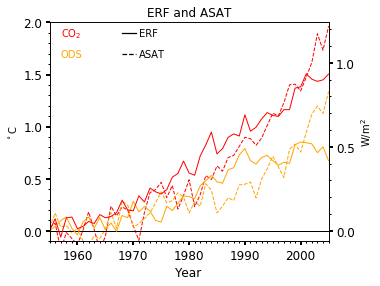

In [29]:

##################################
##4.1c. Timeseries CO2+ODS ERF+ASAT in 1 plot 
##################################
fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.05,wspace=0.3)

#############GSAT+ERF#######################
#############GSAT
ax=axs
#axis
ax.set_xlim([1955, 2005]) 
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim([-0.1, 2])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('$^\circ$C')

##Canesm5
for i,forcing in enumerate (['fixCO2','fixODS']):
    #var
    x=asat['historical']-asat[forcing]
    print (np.mean(x,axis=0))
    # range
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing], linestyle='--') 
    # legend
    ax.text(1957,1.87-i*0.2,labels_dif[forcing],color=colors[forcing])

ax.plot([1968,1970.5],[1.9,1.9], color='k',clip_on=False,linestyle='-',linewidth=1.25) 
ax.text(1971,1.87,'ERF')
ax.plot([1968,1970.5],[1.7,1.7], color='k',clip_on=False,linestyle='--',linewidth=1.25) #cmip6 uncertainty
ax.text(1971,1.67,'ASAT')


#############ERF
ax2 = ax.twinx()
ax2.set_xlim([1955, 2005])

ax2.set_ylim([-0.1*0.62, 2*0.62])
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
ax2.set_xlabel('Year',size='large')
ax2.axhline(y=0,color="black",linewidth=1)
ax2.set_ylabel('W/m$^2$')
ax2.yaxis.set_ticks_position('right')

##plot Canesm5
for i,forcing in enumerate (['fixODS','fixCO2']):
    #var
    x=erf['historical']-erf[forcing]
    # range
    ax2.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing]) #canesm5 timeseries

rpl.add_title(ax,'ERF and ASAT','')    

rpl.mysavefig(fig1,'PLOTS/ASAT+ERF_ODS+CO2.png')

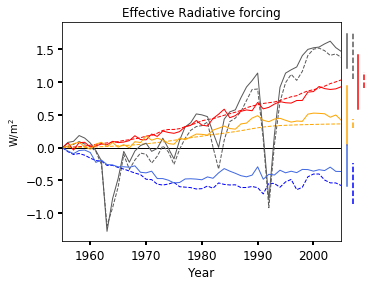

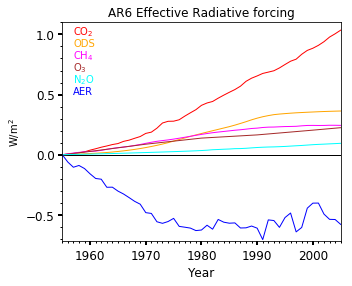

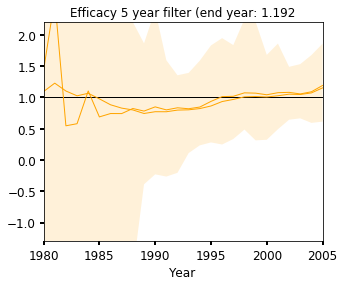

In [30]:



####################################
##4.1c. ERF: include AR6 timeseries##
####################################
fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.1,wspace=0.15)
ax=axs
#axis
ax.set_xlim([1955, 2005]) 
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('W/m$^2$')
#AR6
for i,forcing in enumerate (['tot','co2','ods','aer']):
    ax.plot(years,erf_ar6_cf1955[forcing][0,:],linewidth=1, color=colors_ar6_erf[forcing],linestyle='--') #cmip6 timeseries
    if forcing=='co2': offset=2; 
    else: offset=0
    ax.plot([2006+offset+1,2006+offset+1],[erf_ar6_cf1955[forcing][1,-1],erf_ar6_cf1955[forcing][2,-1]], color=colors_ar6_erf[forcing],linestyle='--',clip_on=False) #cmip6 uncertainty
#CanESM5
for i,forcing in enumerate (['historical','fixCO2','fixODS','fixaerosol']):
    #var
    if forcing=='historical': x=erf_cf1955['historical']
    else: x=erf['historical']-erf[forcing]
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing]) #canesm5 timeseries
    #range
    if forcing=='fixCO2': offset=2; 
    else: offset=0
    ax.plot([2006+offset,2006+offset],[np.min(x[:,-1]),np.max(x[:,-1])], color=colors[forcing],clip_on=False) #canesm5range

##title,save
rpl.add_title(ax,'Effective Radiative forcing')
rpl.mysavefig(fig1,'PLOTS/ERF_timeseries_withAR6timeseries.png')


####################################
##4.1d. ERF: AR6 timeseries##########
####################################
fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.1,wspace=0.15)
ax=axs
#axis
ax.set_xlim([1955, 2005.1]) 
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim([-0.72, 1.1]) 
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('W/m$^2$')
#AR6
for i,forcing in enumerate (['co2','ods','ch4','o3','n2o','aer']):
    ax.plot(years,erf_ar6_cf1955[forcing][0,:],linewidth=1, color=colors_ar6_erf[forcing]) #cmip6 timeseries
    #if forcing=='co2': offset=2; 
    #else: offset=0
    #ax.plot([2006+offset+1,2006+offset+1],[erf_ar6_cf1955[forcing][1,-1],erf_ar6_cf1955[forcing][2,-1]], color=colors_ar6_erf[forcing],linestyle='--',clip_on=False) #cmip6 uncertainty
    # legend
    ax.text(1957,1.0-i*0.1,labels_erf[forcing],color=colors_ar6_erf[forcing])

##title,save
rpl.add_title(ax,'AR6 Effective Radiative forcing')
rpl.mysavefig(fig1,'PLOTS/ERF_AR6.png')



####################################
##4.1e. efficacy: CanESM5timeseries##
####################################
fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.1,wspace=0.15)
ax=axs
#axis
ax.set_xlim([1980, 2005]) 
ax.set_xlabel('Year',size='large')
ax.set_ylim([-1.3, 2.2])
ax.axhline(y=1,color="black",linewidth=1)

ax.plot(years,eff_ods_rm_means,linewidth=1, color=colors['fixODS'])
ax.plot(years,np.mean(eff_ods_rm,axis=0),linewidth=1, color=colors['fixODS'])
ax.fill_between(years,np.min(eff_ods_rm,axis=0), np.max(eff_ods_rm,axis=0),color=colors['fixODS'], alpha=0.15, linewidth=0)

rpl.add_title(ax,'Efficacy '+str(nyear_rm)+' year filter (end year:'+"%6.3f"%np.mean(eff_ods_rm[:,-1],axis=0))        
rpl.mysavefig(fig1,'PLOTS/ODS_efficacy_runningmean'+str(nyear_rm)+'years.png')




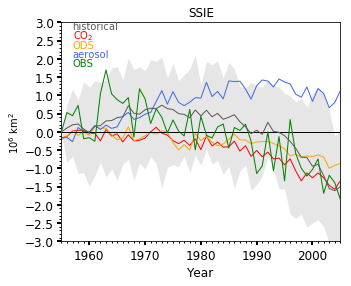

In [31]:

##################################
##4.2. Fig 4: Timeseries SSIE#
##################################

fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.05,wspace=0.3)


#############GSAT
ax=axs
#axis
ax.set_xlim([1955, 2005]) 
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim([-3, 3])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('10$^6$ km$^2$')

#obs
ax.plot(years,ssie_obs[:]-ssie_obs[0],linewidth=1, color='green',zorder=14) 
ax.text(1957,2.8-4*0.25,'OBS',color='green')


##Canesm5
for i,forcing in enumerate (['historical','fixCO2','fixODS','fixaerosol']):
    #var
    if forcing=='historical': x=ssie_cf1955['historical'];zorder=15
    else: x=ssie['historical']-ssie[forcing];zorder=1
    # range
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing],zorder=zorder) 
    if forcing=='historical':
        ax.fill_between(years,np.min(x,axis=0), np.max(x,axis=0),color=colors[forcing], alpha=0.15, linewidth=0)
    # legend
    ax.text(1957,2.8-i*0.25,labels_dif[forcing],color=colors[forcing])


rpl.add_title(ax,'SSIE','')    
rpl.mysavefig(fig1,'PLOTS/SSIE_timeseries.png')



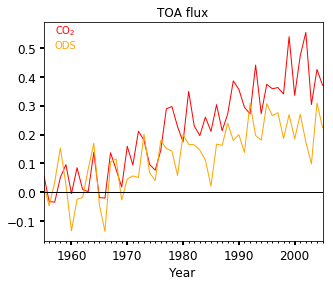

In [32]:

##################################
##4.3. TOA#######################
##################################

fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.05,wspace=0.3)


#############GSAT
ax=axs
#axis
ax.set_xlim([1955, 2005]) 
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.set_ylim([-3, 3])
#ax.yaxis.set_major_locator(MultipleLocator(0.5))
#ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
#ax.set_ylabel('10$^6$ km$^2$')

##Canesm5
for i,forcing in enumerate (['fixCO2','fixODS']):
    #var
    #if forcing=='historical': x=ssie_cf1955['historical'];zorder=15
    #else: x=ssie['historical']-ssie[forcing];zorder=1
    x=toa['historical']-toa[forcing];zorder=1

    # range
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing],zorder=zorder) 
    #if forcing=='historical':
    #    ax.fill_between(years,np.min(x,axis=0), np.max(x,axis=0),color=colors[forcing], alpha=0.15, linewidth=0)
    # legend
    ax.text(1957,0.55-i*0.05,labels_dif[forcing],color=colors[forcing])


rpl.add_title(ax,'TOA flux','')    
rpl.mysavefig(fig1,'PLOTS/TOA_timeseries.png')


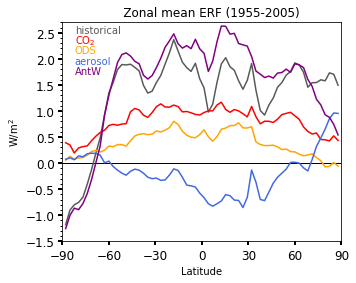

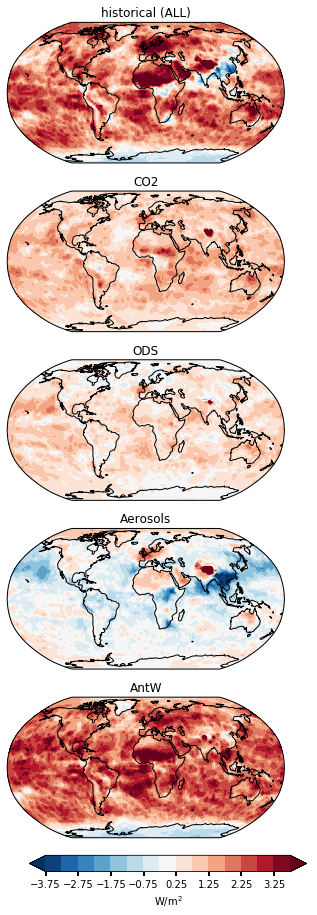

In [33]:
####################################
##4.5. spatial patterns of ERF############
####################################

####################################
##4.5.1 zonal means##################
####################################
fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.05,wspace=0.3)

#############zonal mean ERF#######################
ax=axs
#axis
ax.set_xlim([-90, 90]) 
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.set_xlabel('Latitude')
ax.axhline(y=0,color="black",linewidth=1)

#axis
ax.set_ylim([-1.5, 2.7])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylabel('W/m$^2$')

for i,forcing in enumerate (['historical','fixCO2','fixODS','fixaerosol','AntW']):
    if forcing=='historical':
        plot_data=np.mean(np.mean(erf_zm['historical'][:,-nyear_rm::,:],axis=1)-erf_zm['historical'][:,0,:],axis=0)            
    elif forcing=='AntW':
        plot_data=np.mean(np.mean(erf_zm['fixaerosol'][:,-nyear_rm::,:],axis=1)-erf_zm['fixaerosol'][:,0,:],axis=0)            

    else: 
        plot_data=np.mean(np.mean((erf_zm['historical'][:,-nyear_rm::,:]-erf_zm[forcing][:,-nyear_rm::,:]),axis=1),axis=0)

    ax.plot(lat,plot_data,color=colors[forcing])
    ax.text(-82,2.5-i*0.2,labels_dif[forcing],color=colors[forcing])



rpl.add_title(ax,'     Zonal mean ERF (1955-2005)','')    


rpl.mysavefig(fig1,'PLOTS/ERF_zm.png')

####################################
##4.5.2 2D maps#####################
####################################
#params
#clevs=[-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5]
clevs=[-3.75,-3.25,-2.75,-2.25,-1.75,-1.25,-0.75,-0.25,0.25,0.75,1.25,1.75,2.25,2.75,3.25,3.75]

cf_params=dict(clevs=clevs,cmap='RdBu_r',plot_co=False)
map_params=dict(region='glob_rob')
cf_params['latlon']=True

#set up fig
fig2=plt.figure(figsize=(11,15))
gs = gridspec.GridSpec(nrows=5, ncols=1, right=1,
                        wspace=0.15,hspace=0.2)
#historical
ax=rpl.make_ax_map(gs[0],**map_params);
x=np.mean(np.mean(erf_2d['historical'][:,-nyear_rm::,:,:],axis=1)-erf_2d['historical'][:,0,:,:],axis=0)
cf=rpl.add_cf(ax,lon,lat,x,**cf_params)
rpl.add_title(ax,'historical (ALL)') 
#co2
ax=rpl.make_ax_map(gs[1],**map_params);
x=np.mean(np.mean((erf_2d['historical'][:,-nyear_rm::,:,:]-erf_2d['fixCO2'][:,-nyear_rm::,:,:]),axis=1),axis=0)
cf=rpl.add_cf(ax,lon,lat,x,**cf_params)
rpl.add_title(ax,'CO2') 
#ODS
ax=rpl.make_ax_map(gs[2],**map_params);
x=np.mean(np.mean((erf_2d['historical'][:,-nyear_rm::,:,:]-erf_2d['fixODS'][:,-nyear_rm::,:,:]),axis=1),axis=0)
cf=rpl.add_cf(ax,lon,lat,x,**cf_params)
rpl.add_title(ax,'ODS') 
#Aerosols
ax=rpl.make_ax_map(gs[3],**map_params);
x=np.mean(np.mean((erf_2d['historical'][:,-nyear_rm::,:,:]-erf_2d['fixaerosol'][:,-nyear_rm::,:,:]),axis=1),axis=0)
cf=rpl.add_cf(ax,lon,lat,x,**cf_params)
rpl.add_title(ax,'Aerosols') 
#AntW
ax=rpl.make_ax_map(gs[4],**map_params);
x=np.mean(np.mean(erf_2d['fixaerosol'][:,-nyear_rm::,:,:],axis=1)-erf_2d['fixaerosol'][:,0,:,:],axis=0)
cf=rpl.add_cf(ax,lon,lat,x,**cf_params)
rpl.add_title(ax,'AntW') 
rpl.add_cb(ax,cf,'W/m$^2$',orientation='horizontal',y0scale=-3)
rpl.mysavefig(fig2,'PLOTS/ERF_2d.png')


In [37]:

####################################
##4.5.3 write to netcdf#############
####################################
erf_all=np.mean(np.mean(erf_2d['historical'][:,-nyear_rm::,:,:],axis=1)-erf_2d['historical'][:,0,:,:],axis=0)

outfile = 'DATA/erf_1955-2005_CanESM5_all.nc'
outnc = Dataset(outfile,'w',format='NETCDF4_CLASSIC')
outtime = outnc.createDimension('time', None) 
outlon = outnc.createDimension('longitude',np.size(lon))
outlat = outnc.createDimension('latitude',np.size(lat))  
outlats = outnc.createVariable('latitude','d',('latitude'))
outlons = outnc.createVariable('longitude','d',('longitude'))                    
outfld = outnc.createVariable('ERF','d',('latitude','longitude'),fill_value=-999)
outfld.units = 'W/m2'
outfld.long_name = 'ERF'  
outlats.units = 'degrees_north'
outlats.long_name = 'Latitude'
outlats.standard_name = 'latitude'
outlons.units = 'degrees_east'
outlons.long_name = 'Longitude'
outlons.standard_name = 'longitude'        
outnc.created_by = 'michael.sigmond@ec.gc.ca'
outlats[:] = lat
outlons[:] = lon
outfld[:] = erf_all
outnc.close()

erf_antw=np.mean(np.mean(erf_2d['fixaerosol'][:,-nyear_rm::,:,:],axis=1)-erf_2d['fixaerosol'][:,0,:,:],axis=0)

outfile = 'DATA/erf_1955-2005_CanESM5_antw.nc'
outnc = Dataset(outfile,'w',format='NETCDF4_CLASSIC')
outtime = outnc.createDimension('time', None) 
outlon = outnc.createDimension('longitude',np.size(lon))
outlat = outnc.createDimension('latitude',np.size(lat))  
outlats = outnc.createVariable('latitude','d',('latitude'))
outlons = outnc.createVariable('longitude','d',('longitude'))                    
outfld = outnc.createVariable('ERF','d',('latitude','longitude'),fill_value=-999)
outfld.units = 'W/m2'
outfld.long_name = 'ERF'  
outlats.units = 'degrees_north'
outlats.long_name = 'Latitude'
outlats.standard_name = 'latitude'
outlons.units = 'degrees_east'
outlons.long_name = 'Longitude'
outlons.standard_name = 'longitude'        
outnc.created_by = 'michael.sigmond@ec.gc.ca'
outlats[:] = lat
outlons[:] = lon
outfld[:] = erf_antw
outnc.close()



all 2.041902036653065 1.8116390264601936 2.273403843470983
ods 1.1453157246965588 0.9758046177455244 1.3216016932896109
co2 1.7354404649076864 1.5544423566545704 1.91841433570498
aer -1.059168261907667 -1.202923409598216 -0.8944195701962381
antw 3.133251176045736 2.8502830142066595 3.39916267031715
odso3 0.9553681455049083 0.7774944923037559 1.1338178507487027


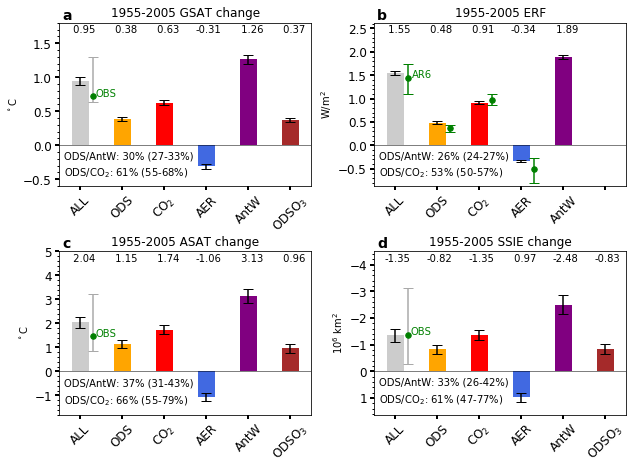

In [35]:
####################################
##4.6. bar plots############
####################################

###################################################
##4.6.1 GSAT+ERF bar plots NEW VERSION: with 5-95% confidence on means
###################################################
print_ensmean=True

#=set up figure=====================================================

fig1, axs = plt.subplots(2,2, figsize=(9,8)); 
fig1.subplots_adjust(bottom=0.2,hspace=0.3,wspace=0.3)

gs1 = gridspec.GridSpec(nrows=2, ncols=2, right=1,
                        wspace=0.25,hspace=0.4)


ax1=plt.subplot(gs1[0])
ax2=plt.subplot(gs1[1])
ax3=plt.subplot(gs1[2])
ax4=plt.subplot(gs1[3])


plot_forcings=['historical','fixODS','fixCO2','fixaerosol','AntW','fixODSO3']
plot_colors=[[0.8,0.8,0.8],colors['fixODS'],colors['fixCO2'],colors['fixaerosol'],'purple',colors['fixODSO3']]


#=GSAT=====================================================
ax=ax1
rpl.add_title(ax,'1955-2005 GSAT change','a')
#xaxis
ax.set_xlim([0.5, 6.5]);  
ax.set_xticks(np.arange(1,6+1))
#yaxis
ymin=-0.6;ymax=1.8;ylabpos=1.65
ax.set_ylim([ymin, ymax])
ax.yaxis.set_major_locator(MultipleLocator(0.5));ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel('$^\circ$C')
#canesm5 
for f,forcing in enumerate(['all','ods','co2','aer','antw','odso3']):
    ax.bar(1+f,dGSAT_meanb_mean[forcing],color=plot_colors[f],width=0.4)
    ax.errorbar(1+f,dGSAT_meanb_mean[forcing],[[dGSAT_meanb_min[forcing]-dGSAT_meanb_mean[forcing]],[dGSAT_meanb_mean[forcing]-dGSAT_meanb_max[forcing]]],capsize=5,ecolor='k')
    if print_ensmean: ax.text(f+1-0.25,ylabpos,"%5.2f"%(dGSAT_meanb_mean[forcing]))

#plot obs & historical range
ax.scatter(1.3,np.mean(gsat_obs[-nyear_rm::])-gsat_obs[0],color='green',s=30,zorder=100)
ax.text(1.35,np.mean(gsat_obs[-nyear_rm::])-gsat_obs[0],'OBS',color='green')
ax.errorbar(1.3,np.mean(dGSAT['all']),[[np.min(dGSAT['all'])-np.mean(dGSAT['all'])],[np.mean(dGSAT['all'])-np.max(dGSAT['all'])]],capsize=5,ecolor='darkgray')

#labels and numbers
#xaxislabel
ax.set_xticklabels(['ALL','ODS','CO$_2$','AER','AntW','ODSO$_3$'],rotation=45)
#ODS/GHG and ODS/CO2 numbers
if print_ensmean: y1=-0.2; y2=-0.45
else: y1=1.6; y2=1.35
ax.text(0.6,y1,'ODS/AntW: {}% ({}-{}%)'.format("%2.0f"%((dGSAT_meanb_mean['ods_antw'])*100),"%2.0f"%((dGSAT_meanb_min['ods_antw'])*100),"%2.0f"%((dGSAT_meanb_max['ods_antw'])*100)))
ax.text(0.6,y2,'ODS/CO$_2$: {}% ({}-{}%)'.format("%2.0f"%((dGSAT_meanb_mean['ods_co2'])*100),"%2.0f"%((dGSAT_meanb_min['ods_co2'])*100),"%2.0f"%((dGSAT_meanb_max['ods_co2'])*100)))

#=ERF=====================================================
ax=ax2
rpl.add_title(ax,'1955-2005 ERF','b')
#xaxis
ax.set_xlim([0.5, 6.5]);  
ax.set_xticks(np.arange(1,6+1))
#yaxis
ax.set_ylim([ymin/0.687, ymax/0.687])
ax.yaxis.set_major_locator(MultipleLocator(0.5)); ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel('W/m$^2$')
#canesm5 
for f,forcing in enumerate(['all','ods','co2','aer','antw']):
    ax.bar(1+f,dERF_meanb_mean[forcing],color=plot_colors[f],width=0.4)
    ax.errorbar(1+f,dERF_meanb_mean[forcing],[[dERF_meanb_min[forcing]-dERF_meanb_mean[forcing]],[dERF_meanb_mean[forcing]-dERF_meanb_max[forcing]]],capsize=5,ecolor='k',zorder=100)
    if print_ensmean: ax.text(f+1-0.25,ylabpos/0.687,"%5.2f"%(dERF_meanb_mean[forcing]))

#plot AR6
for i,forcing in enumerate(['tot','ods','co2','aer']):
    var_min=np.mean(erf_ar6_cf1955[forcing][1,-nyear_rm::])
    var_max=np.mean(erf_ar6_cf1955[forcing][2,-nyear_rm::])
    var_mean=np.mean(erf_ar6_cf1955[forcing][0,-nyear_rm::])   
    ax.scatter(1.3+i,var_mean,color='green',s=30,zorder=100)
    ax.errorbar(1.3+i,var_mean,[[var_min-var_mean],[var_mean-var_max]],capsize=5,ecolor='green')
    if i==0:
        ax.text(1.4,var_mean,'AR6',color='green')

#labels and numbers
#xaxislabel
ax.set_xticklabels(['ALL','ODS','CO$_2$','AER','AntW',''],rotation=45)
#ODS/GHG and ODS/CO2 numbers
if print_ensmean: y1=-0.3; y2=-0.65
else: y1=2.35; y2=2
ax.text(0.6,y1,'ODS/AntW: {}% ({}-{}%)'.format("%2.0f"%((dERF_meanb_mean['ods_antw'])*100),"%2.0f"%((dERF_meanb_min['ods_antw'])*100),"%2.0f"%((dERF_meanb_max['ods_antw'])*100)))
ax.text(0.6,y2,'ODS/CO$_2$: {}% ({}-{}%)'.format("%2.0f"%((dERF_meanb_mean['ods_co2'])*100),"%2.0f"%((dERF_meanb_min['ods_co2'])*100),"%2.0f"%((dERF_meanb_max['ods_co2'])*100)))

#=ASAT=====================================================
ax=ax3
rpl.add_title(ax,'1955-2005 ASAT change','c')
#xaxis
ax.set_xlim([0.5, 6.5]);  
ax.set_xticks(np.arange(1,6+1))
#yaxis
ymin=-1.8;ymax=5;ylabpos=4.55
ax.set_ylim([ymin, ymax])
ax.yaxis.set_major_locator(MultipleLocator(1));ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel('$^\circ$C')
#canesm5 
for f,forcing in enumerate(['all','ods','co2','aer','antw','odso3']):
    ax.bar(1+f,dASAT_meanb_mean[forcing],color=plot_colors[f],width=0.4)
    ax.errorbar(1+f,dASAT_meanb_mean[forcing],[[dASAT_meanb_min[forcing]-dASAT_meanb_mean[forcing]],[dASAT_meanb_mean[forcing]-dASAT_meanb_max[forcing]]],capsize=5,ecolor='k')
    print (forcing,dASAT_meanb_mean[forcing],dASAT_meanb_min[forcing],dASAT_meanb_max[forcing])
    if print_ensmean: ax.text(f+1-0.25,ylabpos,"%5.2f"%(dASAT_meanb_mean[forcing]))

#plot obs & historical range
ax.scatter(1.3,np.mean(asat_obs[-nyear_rm::])-asat_obs[0],color='green',s=30,zorder=100)
ax.text(1.35,np.mean(asat_obs[-nyear_rm::])-asat_obs[0],'OBS',color='green')
ax.errorbar(1.3,np.mean(dASAT['all']),[[np.min(dASAT['all'])-np.mean(dASAT['all'])],[np.mean(dASAT['all'])-np.max(dASAT['all'])]],capsize=5,ecolor='darkgray')

#labels and numbers
#xaxislabel
ax.set_xticklabels(['ALL','ODS','CO$_2$','AER','AntW','ODSO$_3$'],rotation=45)
#ODS/GHG and ODS/CO2 numbers
if print_ensmean: y1=-0.6; y2=-1.35
else: y1=4.5; y2=3.8
ax.text(0.6,y1,'ODS/AntW: {}% ({}-{}%)'.format("%2.0f"%((dASAT_meanb_mean['ods_antw'])*100),"%2.0f"%((dASAT_meanb_min['ods_antw'])*100),"%2.0f"%((dASAT_meanb_max['ods_antw'])*100)))
ax.text(0.6,y2,'ODS/CO$_2$: {}% ({}-{}%)'.format("%2.0f"%((dASAT_meanb_mean['ods_co2'])*100),"%2.0f"%((dASAT_meanb_min['ods_co2'])*100),"%2.0f"%((dASAT_meanb_max['ods_co2'])*100)))

#=SSIE=====================================================
ax=ax4
rpl.add_title(ax,'1955-2005 SSIE change','d')
#xaxis
ax.set_xlim([0.5, 6.5]);  
ax.set_xticks(np.arange(1,6+1))
#yaxis
ymin=-5*0.9;ymax=1.8*0.9;ylabpos=-4.1
ax.set_ylim([ymin, ymax])
ax.yaxis.set_major_locator(MultipleLocator(1));ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.axhline(y=0,color="black",linewidth=0.5)
ax.invert_yaxis() 
ax.set_ylabel('10$^6$ km$^2$')
#canesm5 
for f,forcing in enumerate(['all','ods','co2','aer','antw','odso3']):
    ax.bar(1+f,dSSIE_meanb_mean[forcing],color=plot_colors[f],width=0.4)
    ax.errorbar(1+f,dSSIE_meanb_mean[forcing],[[dSSIE_meanb_min[forcing]-dSSIE_meanb_mean[forcing]],[dSSIE_meanb_mean[forcing]-dSSIE_meanb_max[forcing]]],capsize=5,ecolor='k')
#    print (forcing,dASAT_meanb_mean[forcing],dASAT_meanb_min[forcing],dASAT_meanb_max[forcing])
    if print_ensmean: ax.text(f+1-0.25,ylabpos,"%5.2f"%(dSSIE_meanb_mean[forcing]))

#plot obs & historical range
ax.scatter(1.3,np.mean(ssie_obs[-nyear_rm::])-ssie_obs[0],color='green',s=30,zorder=100)
ax.text(1.35,np.mean(ssie_obs[-nyear_rm::])-ssie_obs[0],'OBS',color='green')
ax.errorbar(1.3,np.mean(dSSIE['all']),[[np.min(dSSIE['all'])-np.mean(dSSIE['all'])],[np.mean(dSSIE['all'])-np.max(dSSIE['all'])]],capsize=5,ecolor='darkgray')

#labels and numbers
#xaxislabel
ax.set_xticklabels(['ALL','ODS','CO$_2$','AER','AntW','ODSO$_3$'],rotation=45)
#ODS/GHG and ODS/CO2 numbers
if print_ensmean: y1=0.5; y2=1.2
else: y1=-4; y2=-3.4
ax.text(0.6,y1,'ODS/AntW: {}% ({}-{}%)'.format("%2.0f"%((dSSIE_meanb_mean['ods_antw'])*100),"%2.0f"%((dSSIE_meanb_min['ods_antw'])*100),"%2.0f"%((dSSIE_meanb_max['ods_antw'])*100)))
ax.text(0.6,y2,'ODS/CO$_2$: {}% ({}-{}%)'.format("%2.0f"%((dSSIE_meanb_mean['ods_co2'])*100),"%2.0f"%((dSSIE_meanb_min['ods_co2'])*100),"%2.0f"%((dSSIE_meanb_max['ods_co2'])*100)))



if print_ensmean: fname='PLOTS/barplot_'+str(2005+1-nyear_rm)+'-2005min1955_withensmeans.png'
else: fname='PLOTS/barplot_'+str(2005+1-nyear_rm)+'-2005min1955.png'
rpl.mysavefig(fig1,fname)



tot 1.4447907815071226 1.156384691226171 1.7878978055521872
ods 0.3605540708 0.292048797348 0.429059344252
co2 0.9737032474542116 0.8570999522032811 1.090078395049915
aer -0.5103280573241694 -0.7553167479514216 -0.21307000801808423


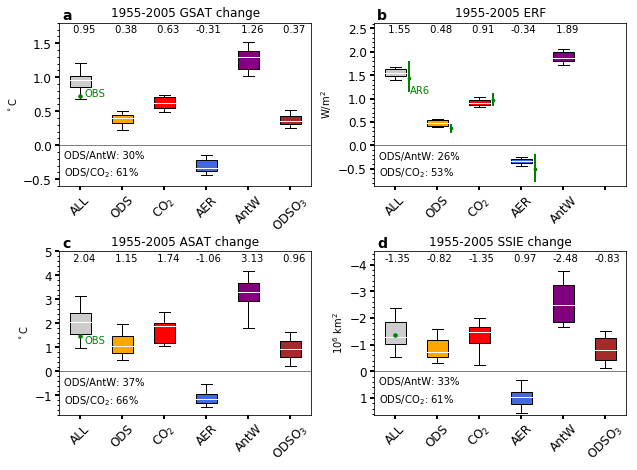

In [36]:


###################################################
##4.6.2 GSAT+ERF bar plots OLD VERSION: with 5-95% of ensemble range
###################################################
print_ensmean=True

#=set up figure=====================================================

fig1, axs = plt.subplots(2,2, figsize=(9,8)); 
fig1.subplots_adjust(bottom=0.2,hspace=0.3,wspace=0.3)

gs1 = gridspec.GridSpec(nrows=2, ncols=2, right=1,
                        wspace=0.25,hspace=0.4)


ax1=plt.subplot(gs1[0])
ax2=plt.subplot(gs1[1])
ax3=plt.subplot(gs1[2])
ax4=plt.subplot(gs1[3])


plot_forcings=['historical','fixODS','fixCO2','fixaerosol','AntW','fixODSO3']
plot_colors=[[0.8,0.8,0.8],colors['fixODS'],colors['fixCO2'],colors['fixaerosol'],'purple',colors['fixODSO3']]



#=GSAT=====================================================
ax=ax1
rpl.add_title(ax,'1955-2005 GSAT change','a')
#xaxis
ax.set_xlim([0.5, 5.5]);  
ax.set_xticks(np.arange(1,6+1))
#yaxis
ymin=-0.6;ymax=1.8;ylabpos=1.65
ax.set_ylim([ymin, ymax])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel('$^\circ$C')
#plot obs
ax.scatter(1,np.mean(gsat_obs[-nyear_rm::])-gsat_obs[0],50,'green','.',zorder=10)
ax.text(1.1,np.mean(gsat_obs[-nyear_rm::])-gsat_obs[0],'OBS',color='green')
#canesm5 collect data
plot_data=np.zeros((nens,6))*np.nan
for f,forcing in enumerate(['all','ods','co2','aer','antw','odso3']):
    plot_data[:,f]=dGSAT[forcing]
#canesm5 box and whisker plots
bp=ax.boxplot(plot_data,
            whis=(5,95),
            medianprops={"color": "white", "linewidth": 1},
            patch_artist=True, #fill with color
            bootstrap=10000,
            showfliers=False,
            widths=0.5) 
for patch, color in zip(bp['boxes'], plot_colors): patch.set_facecolor(color)
#labels and numbers
for f,forcing in enumerate(plot_forcings):
    if print_ensmean: ax.text(f+1-0.25,ylabpos,"%5.2f"%(np.mean(plot_data[:,f])))
    #xaxislabel
    ax.set_xticklabels(['ALL','ODS','CO$_2$','AER','AntW','ODSO$_3$'],rotation=45)
#ODS/GHG and ODS/CO2 numbers
if print_ensmean: y1=-0.2; y2=-0.45
else: y1=1.6; y2=1.35
ax.text(0.6,y1,'ODS/AntW:'+"%3.0f"%((np.mean(plot_data[:,1])/np.mean(plot_data[:,4]))*100)+'%')
ax.text(0.6,y2,'ODS/CO$_2$:'+"%3.0f"%((np.mean(plot_data[:,1])/np.mean(plot_data[:,2]))*100)+'%')



#=ERF=====================================================
ax=ax2
rpl.add_title(ax,'1955-2005 ERF','b')
#xaxis
ax.set_xlim([0.5, 5.5]);  
ax.set_xticks(np.arange(1,3+1))
#yaxis
ax.set_ylim([ymin/0.687, ymax/0.687])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel('W/m$^2$')
#plot AR6
for i,forcing in enumerate(['tot','ods','co2','aer']):
    var_min=np.mean(erf_ar6_cf1955[forcing][1,-nyear_rm::])
    var_max=np.mean(erf_ar6_cf1955[forcing][2,-nyear_rm::])
    var_mean=np.mean(erf_ar6_cf1955[forcing][0,-nyear_rm::])
    ax.plot([i+1.33,i+1.33],[var_min,var_max],color='green',linewidth=2,zorder=15)
    ax.scatter(i+1.33,var_mean,30,'green','.',zorder=15)
    print (forcing,var_mean,var_min,var_max)

#canesm5 collect data
for f,forcing in enumerate(['all','ods','co2','aer','antw','odso3']):
    plot_data[:,f]=dERF[forcing]

#canesm5 raw data
#for f in range(5):
#    ax.scatter(np.ones(nens)*f+1,plot_data[:,f],2,color='k')    
#canesm5 box and whisker plots
bp=ax.boxplot(plot_data,
            whis=(5,95),
            medianprops={"color": "white", "linewidth": 1},
            patch_artist=True, #fill with color
            bootstrap=10000,
            showfliers=False,
            widths=0.5) 
for patch, color in zip(bp['boxes'], plot_colors): patch.set_facecolor(color)
#labels and numbers
for f,forcing in enumerate(['historical','fixODS','fixCO2','fixaerosol','AntW']):
    if print_ensmean: ax.text(f+1-0.25,ylabpos/0.687,"%5.2f"%(np.mean(plot_data[:,f])))
    #xaxislabel
    ax.set_xticklabels(['ALL','ODS','CO$_2$','AER','AntW'],rotation=45)
#AR6 legend
ax.text(1.35,1.1,'AR6',color='green')
#ODS/GHG and ODS/CO2 numbers
if print_ensmean: y1=-0.3; y2=-0.65
else: y1=2.35; y2=2
ax.text(0.6,y1,'ODS/AntW:'+"%3.0f"%((np.mean(plot_data[:,1])/np.mean(plot_data[:,4]))*100)+'%')
ax.text(0.6,y2,'ODS/CO$_2$:'+"%3.0f"%((np.mean(plot_data[:,1])/np.mean(plot_data[:,2]))*100)+'%')
# expand x-axis to correspond to other panels
ax.set_xlim([0.5, 6.5]);  


#=ASAT=====================================================
ax=ax3
rpl.add_title(ax,'1955-2005 ASAT change','c')
#xaxis
ax.set_xticks(np.arange(1,5+1))
#yaxis
ymin=-1.8;ymax=5;ylabpos=4.55
ax.set_ylim([ymin, ymax])
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.axhline(y=0,color="black",linewidth=0.5)
ax.set_ylabel('$^\circ$C')
#plot obs
ax.scatter(1,np.mean(asat_obs[-nyear_rm::])-asat_obs[0],50,'green','.',zorder=10)
ax.text(1.1,np.mean(asat_obs[-nyear_rm::])-asat_obs[0]-0.3,'OBS',color='green')

#canesm5 collect data
plot_data=np.zeros((nens,6))*np.nan
for f,forcing in enumerate(['all','ods','co2','aer','antw','odso3']):
    plot_data[:,f]=dASAT[forcing]


#canesm5 raw data
#for f in range(5):
#    ax.scatter(np.ones(nens)*f+1,plot_data[:,f],2,color='k')    
#canesm5 box and whisker plots
bp=ax.boxplot(plot_data,
            whis=(5,95),
            medianprops={"color": "white", "linewidth": 1},
            patch_artist=True, #fill with color
            bootstrap=10000,
            showfliers=False,
            widths=0.5) 
for patch, color in zip(bp['boxes'], plot_colors): patch.set_facecolor(color)
#labels and numbers
for f,forcing in enumerate(plot_forcings):
    if print_ensmean: ax.text(f+1-0.25,ylabpos,"%5.2f"%(np.mean(plot_data[:,f])))
    #xaxislabel
    ax.set_xticklabels(['ALL','ODS','CO$_2$','AER','AntW','ODSO$_3$'],rotation=45)
#ODS/GHG and ODS/CO2 numbers
if print_ensmean: y1=-0.6; y2=-1.35
else: y1=4.5; y2=3.8
ax.text(0.6,y1,'ODS/AntW:'+"%3.0f"%((np.mean(plot_data[:,1])/np.mean(plot_data[:,4]))*100)+'%')
ax.text(0.6,y2,'ODS/CO$_2$:'+"%3.0f"%((np.mean(plot_data[:,1])/np.mean(plot_data[:,2]))*100)+'%')


#=SSIE=====================================================
ax=ax4
rpl.add_title(ax,'1955-2005 SSIE change','d')
#xaxis
ax.set_xlim([0.5, 5.5]);  
ax.set_xticks(np.arange(1,5+1))
#yaxis
ymin=-5*0.9;ymax=1.8*0.9;ylabpos=-4.1
ax.set_ylim([ymin, ymax])
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.axhline(y=0,color="black",linewidth=0.5)
ax.invert_yaxis() 
ax.set_ylabel('10$^6$ km$^2$')
#plot obs
ax.scatter(1,np.mean(ssie_obs[-nyear_rm::])-ssie_obs[0],50,'green','.',zorder=10)
#ax.text(1.1,np.mean(ssie_obs[-nyear_rm::])-ssie_obs[0],'OBS',color='green')

#canesm5 collect data
plot_data=np.zeros((nens,6))*np.nan
for f,forcing in enumerate(['all','ods','co2','aer','antw','odso3']):
    plot_data[:,f]=dSSIE[forcing]
#canesm5 raw data
#for f in range(5):
#    ax.scatter(np.ones(nens)*f+1,plot_data[:,f],2,color='k')    
#canesm5 box and whisker plots
bp=ax.boxplot(plot_data,
            whis=(5,95),
            medianprops={"color": "white", "linewidth": 1},
            patch_artist=True, #fill with color
            bootstrap=10000,
            showfliers=False,
            widths=0.5) 
for patch, color in zip(bp['boxes'], plot_colors): patch.set_facecolor(color)
#labels and numbers
for f,forcing in enumerate(plot_forcings):
    if print_ensmean: ax.text(f+1-0.25,ylabpos,"%5.2f"%(np.mean(plot_data[:,f])))
    #xaxislabel
    ax.set_xticklabels(['ALL','ODS','CO$_2$','AER','AntW','ODSO$_3$'],rotation=45)
#ODS/GHG and ODS/CO2 numbers
if print_ensmean: y1=0.5; y2=1.2
else: y1=-4; y2=-3.4
ax.text(0.6,y1,'ODS/AntW:'+"%3.0f"%((np.mean(plot_data[:,1])/np.mean(plot_data[:,4]))*100)+'%')
ax.text(0.6,y2,'ODS/CO$_2$:'+"%3.0f"%((np.mean(plot_data[:,1])/np.mean(plot_data[:,2]))*100)+'%')


if print_ensmean: fname='PLOTS/barplot_'+str(2005+1-nyear_rm)+'-2005min1955_withensmeans_OLD.png'
else: fname='PLOTS/barplot_'+str(2005+1-nyear_rm)+'-2005min1955_OLD.png'
rpl.mysavefig(fig1,fname)

